In [47]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
## Load cleaned approved loan data
df = pd.read_csv('approved_loan_2015_clean.csv',low_memory=False)

In [22]:
p_optimal='l1'

In [4]:
df.head()

,Unnamed: 0,loan_amnt,annual_inc,fico_range_low,fico_range_high,num_actv_bc_tl,tot_cur_bal,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,...,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,int_rate
0,0,16000.0,62000.0,720.0,724.0,4.0,227708.0,3.0,5.0,0.0,...,0,0,0,0,0,0,0,0,0,8.49
1,1,8000.0,45000.0,670.0,674.0,3.0,148154.0,2.0,11.0,0.0,...,0,0,0,0,0,0,0,0,0,10.78
2,2,10000.0,41600.0,695.0,699.0,2.0,168304.0,2.0,5.0,0.0,...,0,0,0,0,0,0,0,0,0,10.78
3,3,24700.0,65000.0,715.0,719.0,5.0,204396.0,4.0,5.0,0.0,...,0,0,0,0,0,0,0,0,0,11.99
4,4,10000.0,42500.0,705.0,709.0,4.0,41166.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,11.99


In [10]:
c=0.0820849986238988

In [13]:
df2 = df.copy()
df2 = df2.ix[:,1:]

In [15]:
df2.head()

,loan_amnt,annual_inc,fico_range_low,fico_range_high,num_actv_bc_tl,tot_cur_bal,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,dti,...,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,int_rate
0,16000.0,62000.0,720.0,724.0,4.0,227708.0,3.0,5.0,0.0,28.92,...,0,0,0,0,0,0,0,0,0,8.49
1,8000.0,45000.0,670.0,674.0,3.0,148154.0,2.0,11.0,0.0,21.23,...,0,0,0,0,0,0,0,0,0,10.78
2,10000.0,41600.0,695.0,699.0,2.0,168304.0,2.0,5.0,0.0,15.78,...,0,0,0,0,0,0,0,0,0,10.78
3,24700.0,65000.0,715.0,719.0,5.0,204396.0,4.0,5.0,0.0,16.06,...,0,0,0,0,0,0,0,0,0,11.99
4,10000.0,42500.0,705.0,709.0,4.0,41166.0,0.0,4.0,0.0,31.04,...,0,0,0,0,0,0,0,0,0,11.99


In [16]:
from sklearn.model_selection import train_test_split
# Split training(labeled) and test(unlabled) 
#df_train = df_bi[df_chin_bi['cuisine_Chinese'] != 2]
#df_test = df_chin_bi[df_chin_bi['Loan_status'] == 2]

# reduce data volumn by randomly selecting instances
np.random.seed(99)

ind = np.random.randint(0, len(df2), 100000)
df_reduced = df2.ix[ind, :]

df_labeled = df_reduced[df_reduced['Target']!=2]
df_unlabeled = df_reduced[df_reduced['Target']==2]

X = df_labeled.drop('Target',axis=1)
Y = df_labeled['Target']
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_vali , Y_train , Y_vali = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

In [23]:
lr = LogisticRegression(C=c, penalty=p_optimal, random_state=99)
lr.fit(X_train, Y_train)

LogisticRegression(C=0.0820849986239, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=99,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [24]:
cost_matrix = pd.DataFrame([[0.101, -0.647], [0, 0]], columns=['p', 'n'], index=['Y', 'N'])
print ("Cost matrix")
print (cost_matrix)

Cost matrix
       p      n
Y  0.101 -0.647
N  0.000  0.000


In [25]:
probabilities = lr.predict_proba(X_test)[:, 1]

In [26]:
prediction = probabilities > 0.5

# Build and print a confusion matrix
confusion_matrix_large = pd.DataFrame(metrics.confusion_matrix(Y_test, prediction, labels=[1, 0]).T,
                                columns=['p', 'n'], index=['Y', 'N'])
print (confusion_matrix_large)

      p     n
Y  4209  1522
N   329   475


In [42]:
#MANUAL ROC CALCULATION

n=[1,2,3,4,5,6,7,8,9]
TPR=[]
FPR=[]

for i in n:
    prediction = probabilities > ((i*1.0)/10)
    confusion_matrix_large = pd.DataFrame(metrics.confusion_matrix(Y_test, prediction, labels=[1, 0]).T,columns=['p', 'n'], index=['Y', 'N'])
    TPR.append(1.0*confusion_matrix_large['p']['Y']/(1.0*(confusion_matrix_large['p']['Y']+confusion_matrix_large['p']['N'])))
    FPR.append(1.0*confusion_matrix_large['n']['Y']/(1.0*(confusion_matrix_large['n']['Y']+confusion_matrix_large['n']['N']))) 

In [51]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, lr.predict_proba(X_test)[:,1])

In [56]:
thresholds

array([ 0.9834676 ,  0.95883673,  0.95877152, ...,  0.20111337,
        0.20065485,  0.15679253])

In [57]:
profits=[]
for i in thresholds:
    prediction = probabilities > i
    confusion_matrix_large = pd.DataFrame(metrics.confusion_matrix(Y_test, prediction, labels=[1, 0]).T,columns=['p', 'n'], index=['Y', 'N'])
    profits.append((1.0*confusion_matrix_large['p']['Y'])*cost_matrix['p']['Y']+(1.0*confusion_matrix_large['n']['Y'])*cost_matrix['n']['Y'])


In [58]:
profits

[0.0,
 2.4240000000000004,
 2.5250000000000004,
 3.3929999999999998,
 3.4939999999999998,
 4.5640000000000001,
 4.6650000000000009,
 7.2910000000000004,
 7.3919999999999995,
 10.826000000000001,
 10.927,
 11.694000000000001,
 11.795,
 13.370000000000001,
 12.824000000000002,
 13.288000000000002,
 13.389000000000001,
 13.752000000000002,
 13.853000000000002,
 16.277000000000001,
 16.378,
 17.994,
 18.095000000000002,
 17.448,
 17.548999999999999,
 18.417000000000002,
 18.518000000000001,
 19.225000000000001,
 19.326000000000001,
 18.679000000000002,
 18.780000000000001,
 19.143000000000001,
 19.244,
 19.001000000000001,
 19.102000000000004,
 19.304000000000002,
 19.405000000000001,
 18.616000000000003,
 18.717000000000002,
 18.07,
 18.170999999999999,
 17.928000000000001,
 18.029,
 17.483000000000004,
 17.584000000000003,
 16.937000000000001,
 17.038,
 17.341000000000001,
 17.442,
 17.603000000000002,
 17.057000000000002,
 18.228000000000002,
 18.329000000000001,
 18.085999999999999,
 1

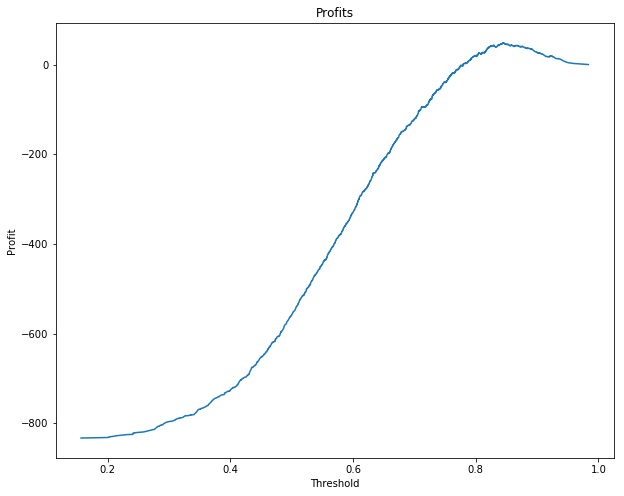

In [64]:
plt.plot(thresholds,profits)
plt.xlabel("Threshold")
plt.ylabel("Profit")
plt.title("Profits")
